## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/intersection/polyhedra_intersection.html")


code =

    'function [z, history] = polyhedra_intersection(A1, b1, A2, b2, rho, alpha)
     % polyhedra_intersection  Find point in intersection of two polyhedra via 
     %  ADMM
     %
     % [x, history] = polyhedra_intersection(A1, b1, A2, b2, rho, alpha)
     % 
     % Solves the following problem via ADMM:
     % 
     %   find         x
     %   subject to   x in { y | A1 y <= b1 }
     %                x in { y | A2 y <= b2 }.
     % 
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     % 
     %
     % More information can be found in the paper linked at:
     % http://www.stanford.edu/~boyd/papers/distr_opt

In [2]:
%%file polyhedra_intersection.m

function [z, history] = polyhedra_intersection(A1, b1, A2, b2, rho, alpha)
% polyhedra_intersection  Find point in intersection of two polyhedra via 
%  ADMM
%
% [x, history] = polyhedra_intersection(A1, b1, A2, b2, rho, alpha)
% 
% Solves the following problem via ADMM:
% 
%   find         x
%   subject to   x in { y | A1 y <= b1 }
%                x in { y | A2 y <= b2 }.
% 
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and 
% dual residual norms, and the tolerances for the primal and dual residual 
% norms at each iteration.
% 
% rho is the augmented Lagrangian parameter. 
%
% alpha is the over-relaxation parameter (typical values for alpha are 
% between 1.0 and 1.8).
% 
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

n = size(A1,2);

%% ADMM solver

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);

if ~QUIET
 fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
   'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

 % x-update
 % use cvx to find point in first polyhedra
 cvx_begin quiet
     variable x(n)
     minimize (sum_square(x - (z - u)))
     subject to
         A1*x <= b1
 cvx_end

 % z-update with relaxation
 zold = z;
 x_hat = alpha*x + (1 - alpha)*zold;
 % use cvx to find point in second polyhedra
 cvx_begin quiet
     variable z(n)
     minimize (sum_square(x_hat - (z - u)))
     subject to
         A2*z <= b2
 cvx_end

 u = u + (x_hat - z);

 % diagnostics, reporting, termination checks

 history.objval(k)  = 0;
 history.r_norm(k)  = norm(x - z);
 history.s_norm(k)  = norm(-rho*(z - zold));

 history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
 history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

 if ~QUIET
     fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
         history.r_norm(k), history.eps_pri(k), ...
         history.s_norm(k), history.eps_dual(k), history.objval(k));
 end

 if (history.r_norm(k) < history.eps_pri(k) && ...
    history.s_norm(k) < history.eps_dual(k))
      break;
 end
end

if ~QUIET
 toc(t_start);
end

end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/polyhedra_intersection.m'.


# Examples

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/intersection/polyhedra_intersection_example.html")


eg_code =

    '% Find point in intersection of two polyhedra, given by
     % { x | A1 x <= b1 } and { x | A2 x <= b2 }.
     
     %% Generate problem data
     
     randn('state', 0);
     rand('state', 0);
     
     n = 5;      % dimension of variable
     m1 = 10;    % number of faces for polyhedra 1
     m2 = 12;    % number of faces for polyhedra 2
     
     c1 = 10*randn(n,1);        % center of polyhedra 1
     c2 = -10*randn(n,1);       % center of polyhedra 2
     
     % consider the following picture:
     %
     %       a1
     % c ---------> x
     %
     % from the center "c", we travel along vector "a1" (not necessarily a unit
     % vector) until we reach x. at "x", a1'x = b. a point y is to the left of x
     % if a1'y <= b.
     %
     
     % pick m1 random directions with different magnitudes
     A1 = diag(1 + rand(m1,1))*randn(m1,n);
     % the value of b is found by traveling from the center along the normal
     % vectors in A1 and taking its inner product

In [4]:
% Find point in intersection of two polyhedra, given by
% { x | A1 x <= b1 } and { x | A2 x <= b2 }.

### Generate problem data

####  required: install cvx from http://cvxr.com/cvx/download/

In [5]:
randn('state', 0);
rand('state', 0);

n = 5;      % dimension of variable
m1 = 10;    % number of faces for polyhedra 1
m2 = 12;    % number of faces for polyhedra 2

c1 = 10*randn(n,1);        % center of polyhedra 1
c2 = -10*randn(n,1);       % center of polyhedra 2

% consider the following picture:
%
%       a1
% c ---------> x
%
% from the center "c", we travel along vector "a1" (not necessarily a unit
% vector) until we reach x. at "x", a1'x = b. a point y is to the left of x
% if a1'y <= b.
%

% pick m1 random directions with different magnitudes
A1 = diag(1 + rand(m1,1))*randn(m1,n);
% the value of b is found by traveling from the center along the normal
% vectors in A1 and taking its inner product with A1.
b1 = diag(A1*(c1*ones(1,m1) + A1'));

% pick m2 random directions with different magnitudes
A2 = diag(1 + rand(m2,1))*randn(m2,n);
% the value of b is found by traveling from the center along the normal
% vectors in A1 and taking its inner product with A1.
b2 = diag(A2*(c2*ones(1,m2) + A2'));

% find the distance between the two polyhedra--make sure they overlap by
% checking if the distance is 0
cvx_begin quiet
 variables x(n) y(n)
 minimize sum_square(x - y)
 subject to
     A1*x <= b1
     A2*y <= b2
cvx_end

% if the distance is not 0, expand A1 and A2 by a little more than half the
% distance
if norm(x-y) > 1e-4,
 A1 = (1 + 0.5*norm(x-y))*A1;
 A2 = (1 + 0.5*norm(x-y))*A2;
 % recompute b's as appropriate
 b1 = diag(A1*(c1*ones(1,m1) + A1'));
 b2 = diag(A2*(c2*ones(1,m2) + A2'));
end

### Solve problem

In [6]:
[x history] = polyhedra_intersection(A1, b1, A2, b2, 1.0, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    6.8712	    0.1385	   13.8243	    0.0689	      0.00
  2	    4.6972	    0.1809	    3.3125	    0.0374	      0.00
  3	    0.9612	    0.1692	    1.6155	    0.0354	      0.00
  4	    0.4124	    0.1753	    1.3752	    0.0313	      0.00
  5	    0.8436	    0.1839	    0.9908	    0.0229	      0.00
  6	    1.0712	    0.1884	    0.5221	    0.0122	      0.00
  7	    1.0907	    0.1888	    0.0446	    0.0012	      0.00
  8	    0.1019	    0.1888	    0.0001	    0.0002	      0.00
 4.844769 


### Reporting

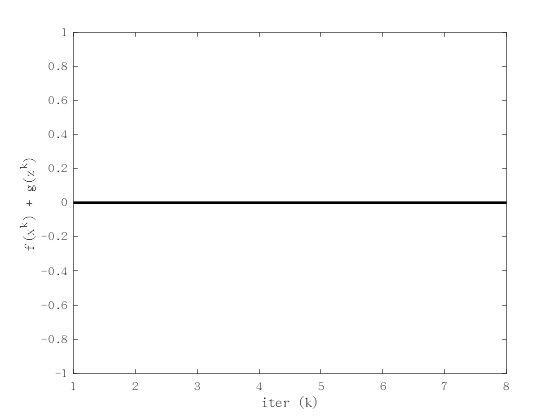

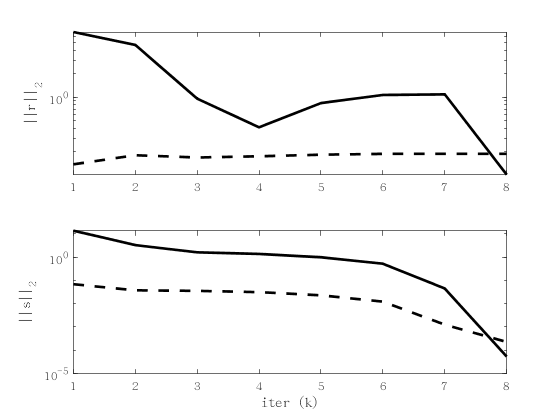

In [7]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');